In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm
tf.compat.v1.enable_v2_behavior()

from sklearn.decomposition import PCA

In [3]:
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics, py_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy, epsilon_greedy_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import array_spec
from tf_agents.environments import utils, wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import py_driver

In [4]:
class RandomSophisticatedFunction(object):
    """A function converting an input into a high-dimensional object."""
    def __init__(self, n=10, k=100, seed=11):
        
        tf.random.set_seed(seed)
        
        self.model = tf.keras.Sequential([
            #tf.keras.layers.Dense(10, input_shape=(n,), activation='relu'),
            #tf.keras.layers.Dense(100),
            tf.keras.layers.Dense(k, bias_initializer='random_uniform'),
        ])
        
    def __call__(self, x):
        return self.model(np.array([x])).numpy()[0]
    
assert RandomSophisticatedFunction(n=3, k=5, seed=1)([10,10,10]).shape == (5,)

In [5]:
RandomSophisticatedFunction(n=3, seed=1)([10,10,10])

array([ 0.42107463,  1.9756418 ,  0.5922047 ,  2.2600236 , -3.1435785 ,
       -2.6043975 ,  0.5879588 , -3.8485632 , -0.80992734, -1.9239613 ,
       -1.5292026 ,  1.5467768 ,  1.9360533 ,  2.2978485 ,  0.28572452,
       -0.5248615 , -3.4031332 , -2.4824233 ,  0.26168972,  3.522755  ,
       -0.76830816, -4.5024695 , -5.973458  , -0.08354399,  1.021549  ,
        3.0432026 , -3.2647412 , -0.32379162,  1.3775078 , -1.1641221 ,
        5.360249  ,  2.485961  , -0.30522534,  0.49440664,  0.4870112 ,
        0.3299148 , -0.3536277 ,  1.748136  ,  1.4803805 , -1.2345239 ,
        0.06540942, -3.3158581 ,  0.52739054, -6.083921  ,  3.3707094 ,
       -5.578037  ,  0.7661759 ,  1.7714828 , -0.18969497,  0.78672135,
        0.11239807, -2.2097538 , -2.147925  , -0.14433458,  0.74999607,
        0.5272489 , -1.97522   ,  4.380763  ,  0.5881273 ,  1.828241  ,
        3.938662  ,  3.125843  , -4.634218  , -1.1190304 ,  1.6213365 ,
        1.3446006 , -1.1212261 , -1.0577558 ,  2.706028  , -1.45

In [6]:
class VectorIncrementEnvironment(object):
    """VectorIncrement environment."""
    def __init__(self, n=10, k=20):
        self.n = n
        self.k = k
        self.e = RandomSophisticatedFunction(n=n, k=k)
        self.s = np.zeros(self.n)

    def encoded_state(self):
        return np.array(self.e(self.s), dtype=np.float32)
        
    def reset(self):
        self.s = np.zeros(self.n)
        return self.encoded_state()

    def step(self, action):
        assert action in range(0, self.n + 1)
        
        s_old = np.copy(self.s)
        if action > 0:
            self.s[action - 1] += 1
            
            if max(s_old) - min(s_old) > 0:
                r = (max(s_old) - s_old[action - 1]) / (max(s_old) - min(s_old))
            else:
                r = 0
        else:
            r = 0
            
        #def metric(x):
        #    return max(x) - np.mean(x)
       # 
       # r = (metric(s_old) - metric(self.s)) > 0
        
        
            
        return {'reward': float(r),
               'state': np.copy(self.s),
               'observation': self.encoded_state()}
        
        
    def __repr__(self):
        return str(self.s)

In [7]:
n = 2
env = VectorIncrementEnvironment(n=n, k=10)

In [8]:
env.s

array([0., 0.])

In [9]:
env.step(2)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



{'reward': 0.0,
 'state': array([0., 1.]),
 'observation': array([-0.13828124,  0.3408532 , -0.12106577, -0.00676261,  0.01375737,
         0.35241634,  0.15493019, -0.5223689 , -0.217097  ,  0.5671197 ],
       dtype=float32)}

In [10]:
env.reset()

array([ 0.00582539, -0.04459292, -0.04060308,  0.01915617, -0.0472003 ,
       -0.02875542, -0.04071616, -0.01283339,  0.0458479 ,  0.00474627],
      dtype=float32)

# Testing if PCA works

In [11]:
obs = []
states = []

for _ in range(3):
    o = env.reset()
    for _ in range(50):
        a = np.random.randint(0, n + 1)
        result = env.step(a)
        obs.append(result['observation'])
        states.append(result['state'])
states = np.array(states)

In [12]:
pca = PCA(n_components=2)
pca = pca.fit_transform(obs)

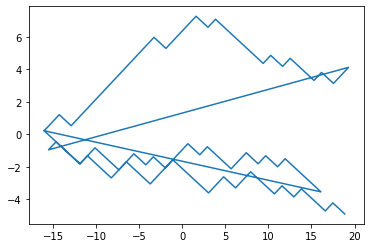

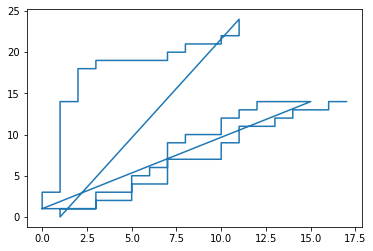

In [13]:
plt.figure()
plt.plot(pca[:, 0], pca[:, 1])
plt.show()
plt.figure()
plt.plot(states[:, 0], states[:, 1])
plt.show()

### PCA does not recover the variables we want...

The increase is NOT monotonous

# Running RL with tf.agents

In [14]:
num_iterations = 20000 # @param {type: "integer"}

initial_collect_steps = 1000 # @param {type: "integer"}
collect_steps_per_iteration = 1
replay_buffer_max_length = 1000

batch_size = 256
learning_rate = 1e-3
log_interval = 1

num_eval_episodes = 10
eval_interval = 1

In [15]:
v_n = 2
v_k = 2
v_seed = 10

In [16]:
class VectorIncrementEnvironmentTFAgents(tf_py_environment.TFPyEnvironment):
  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=v_n, name='action')
    self._observation_spec = array_spec.ArraySpec(
        shape=(v_k,), dtype=np.float32, name='observation')
    self._time_step_spec = ts.time_step_spec(self._observation_spec)
    
    self.env = VectorIncrementEnvironment(n=v_n, k=v_k)
    self._state = self.env.encoded_state()
    self._episode_ended = False
    self._batched = False
   # self._batch_size = None
    
  def batch_size(self):
    return None

  @property
  def batched(self):
    return False

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self.env.reset()
    self._state = self.env.encoded_state()
    self._episode_ended = False
    return ts.restart(self._state)

  def _step(self, action):

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    res = self.env.step(action)
    self._state = self.env.encoded_state()

    return ts.transition(self._state, reward=res['reward'], discount=1.0)


In [17]:
# checking that the environment works
env = VectorIncrementEnvironmentTFAgents()
env = wrappers.TimeLimit(env, 20)
utils.validate_py_environment(env, episodes=5)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [18]:
train_env = tf_py_environment.TFPyEnvironment(env)
#train_env = env

In [19]:
fc_layer_params = (30, 30, 30, 30, 30, 30)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)


In [20]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
#optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


In [21]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [22]:
num_episodes = tf_metrics.NumberOfEpisodes()
env_steps = tf_metrics.EnvironmentSteps()
avg_return = tf_metrics.AverageReturnMetric()
act_hist = tf_metrics.ChosenActionHistogram()

observers = [num_episodes, env_steps, avg_return, replay_buffer.add_batch, act_hist]

#tf_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(agent.collect_policy, 0.5)

tf_env = train_env
tf_policy = agent.collect_policy

driver = dynamic_episode_driver.DynamicEpisodeDriver(
    tf_env, tf_policy, observers, num_episodes=batch_size)

# Initial driver.run will reset the environment and initialize the policy.
final_time_step, policy_state = driver.run()

print('final_time_step', final_time_step)
print('Number of Steps: ', env_steps.result().numpy())
print('Number of Episodes: ', num_episodes.result().numpy())

final_time_step TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.00582539, -0.04459292]], dtype=float32)>)
Number of Steps:  5120
Number of Episodes:  256


In [23]:
avg_return.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.2>

In [24]:
act_hist.result()

<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [25]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

In [26]:
### (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

returns = []

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  # Continue running from previous state
  final_time_step, _ = driver.run(final_time_step, policy_state)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    ret = avg_return.result()
    print('step = {0}: Average Return = {1}'.format(step, ret))
    avg_return.reset()
    returns.append(ret)

step = 1: loss = 0.049587905406951904
step = 1: Average Return = 0.4000000059604645
step = 2: loss = 0.029040616005659103
step = 2: Average Return = 0.20000000298023224
step = 3: loss = 0.031366411596536636
step = 3: Average Return = 0.30000001192092896
step = 4: loss = 0.01981891319155693
step = 4: Average Return = 0.4000000059604645
step = 5: loss = 0.03474270552396774
step = 5: Average Return = 0.6000000238418579
step = 6: loss = 0.017550524324178696
step = 6: Average Return = 0.5
step = 7: loss = 0.028636574745178223
step = 7: Average Return = 0.5
step = 8: loss = 0.01055444497615099
step = 8: Average Return = 0.699999988079071
step = 9: loss = 0.016182754188776016
step = 9: Average Return = 0.800000011920929
step = 10: loss = 0.0542275495827198
step = 10: Average Return = 0.6000000238418579
step = 11: loss = 0.04458712041378021
step = 11: Average Return = 0.30000001192092896
step = 12: loss = 0.06075861677527428
step = 12: Average Return = 0.800000011920929
step = 13: loss = 0.045

step = 106: loss = 34566.671875
step = 106: Average Return = 0.800000011920929
step = 107: loss = 38103.7890625
step = 107: Average Return = 0.30000001192092896
step = 108: loss = 48956.359375
step = 108: Average Return = 0.699999988079071
step = 109: loss = 53347.6640625
step = 109: Average Return = 0.5
step = 110: loss = 61065.1484375
step = 110: Average Return = 0.699999988079071
step = 111: loss = 70019.21875
step = 111: Average Return = 0.5
step = 112: loss = 82519.0
step = 112: Average Return = 1.2000000476837158
step = 113: loss = 96780.78125
step = 113: Average Return = 0.30000001192092896
step = 114: loss = 112410.9609375
step = 114: Average Return = 0.6000000238418579
step = 115: loss = 130545.171875
step = 115: Average Return = 1.2000000476837158
step = 116: loss = 148221.09375
step = 116: Average Return = 0.5
step = 117: loss = 173692.375
step = 117: Average Return = 0.5
step = 118: loss = 200433.484375
step = 118: Average Return = 0.800000011920929
step = 119: loss = 24604

KeyboardInterrupt: 

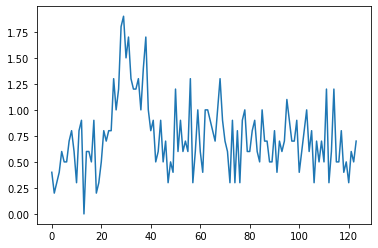

In [27]:
plt.plot(returns)

In [ ]:
replay_buffer.clear()

In [ ]:
num_episodes = tf_metrics.NumberOfEpisodes()
env_steps = tf_metrics.EnvironmentSteps()
avg_return = tf_metrics.AverageReturnMetric()
act_hist = tf_metrics.ChosenActionHistogram()

observers = [num_episodes, env_steps, avg_return, replay_buffer.add_batch, act_hist]

#tf_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(agent.collect_policy, 0.5)

tf_env = train_env
tf_policy = agent.policy

driver = dynamic_episode_driver.DynamicEpisodeDriver(
    tf_env, tf_policy, observers, num_episodes=batch_size)

# Initial driver.run will reset the environment and initialize the policy.
final_time_step, policy_state = driver.run()

print('final_time_step', final_time_step)
print('Number of Steps: ', env_steps.result().numpy())
print('Number of Episodes: ', num_episodes.result().numpy())

In [ ]:
avg_return.result()

In [ ]:
replay_buffer.clear()

In [ ]:
for r in replay_buffer.gather_all().observation[:10].numpy()[0]:
    print(r)

In [ ]:
xy = replay_buffer.gather_all().observation.numpy()[0]

In [ ]:
plt.hist(replay_buffer.gather_all().action.numpy()[0])

In [ ]:
replay_buffer.gather_all().action.numpy().shape

In [ ]:
plt.plot(xy[:, 0], xy[:, 1])
plt.plot([0, 10], [0, 10])

# Hardcoded agent

In [ ]:
o = train_env.reset().observation.numpy()[0]
total_reward = 0
while True:
    act = 2 if o[0] > o[1] else 1
    step = train_env.step(act)
    o = step.observation.numpy()[0]
    r = np.array(step.reward[0])
    total_reward += r
    print(act, o, r)
    if step.step_type == 2:
        break
print(total_reward)

### no preproc
5 -> 4.1 (any learning rate) dqn
10 -> 10.0

Why is there a difference???


### preproc
* ```
    tf.keras.layers.Dense(10, input_shape=(n,), activation='relu'),
            #tf.keras.layers.Dense(100),
            tf.keras.layers.Dense(k, bias_initializer='random_uniform'),
            ```
  relu (30, 30, 30, 30, 30, 30), 2->5, seed=10, 20 steps
  CANT LEARN

* Removed the first layer, now only have a linear transform -> same thing
* trying adam -- same thing. rate $10^{-3}$ goes up! Trying with more iterations

Trying PPO in another notebook...